In [1]:
import numpy as np
import pandas as pd
import shap
import time
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique())< 20
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def feature_selector(X):
    continuous_columns = X.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(X[feature].unique())< 20
    ]
    categorical_columns = X.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    dummies_features = pd.get_dummies(X[categorical_columns])
    X = pd.concat([X, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    X = X.drop(categorical_columns, axis=1)

    return X

In [4]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=100
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
payments = pd.read_csv('./data/payments.csv')

In [7]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [8]:
payments = payments.rename(columns={ payments.columns[1]: "APPLICATION_NUMBER_payments" })

In [9]:
payments['AMT_PAYMENT'].value_counts()

9000.000     18573
2250.000     13648
4500.000     13433
6750.000     12841
3375.000     10738
             ...  
35946.720        1
35253.090        1
17542.755        1
17657.370        1
32094.630        1
Name: AMT_PAYMENT, Length: 326874, dtype: int64

In [10]:
def payments_features_gen(df):
    df['AMT_PAYMENT_and_NUM_INSTALMENT_VERSION'] = df['AMT_PAYMENT']/df['NUM_INSTALMENT_VERSION']
    df['AMT_PAYMENT_and_NUM_INSTALMENT_NUMBER'] = df['AMT_PAYMENT']/df['NUM_INSTALMENT_NUMBER']
    df['AMT_PAYMENT_and_DAYS_INSTALMENT'] = df['AMT_PAYMENT']/df['DAYS_INSTALMENT']
    df['AMT_PAYMENT_and_DAYS_ENTRY_PAYMENT'] = df['AMT_PAYMENT']/df['DAYS_ENTRY_PAYMENT']
    df['AMT_PAYMENT_and_AMT_INSTALMENT'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']

    return df

In [11]:
payments = payments_features_gen(payments)
payments = payments.replace([-np.inf, np.inf], [np.nan, np.nan])

In [12]:
payments

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER_payments,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_PAYMENT_and_NUM_INSTALMENT_VERSION,AMT_PAYMENT_and_NUM_INSTALMENT_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT,AMT_PAYMENT_and_DAYS_ENTRY_PAYMENT,AMT_PAYMENT_and_AMT_INSTALMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615,12156.6150,2431.323000,12.132350,11.976961,1.000000
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645,10047.6450,772.895769,22.732229,23.258437,0.546289
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945,5499.9450,549.994500,687.493125,239.128043,1.000000
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145,NaN,86.367622,17.794334,17.794334,1.000000
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735,NaN,2.487857,0.115331,0.115331,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023927,50029793,123728077,0.0,123,993.0,993.0,2700.000,2700.000,NaN,21.951220,2.719033,2.719033,1.000000
1023928,48418780,123568892,0.0,73,529.0,529.0,232.335,232.335,NaN,3.182671,0.439197,0.439197,1.000000
1023929,49942303,123494001,2.0,24,389.0,393.0,23284.485,23284.485,11642.2425,970.186875,59.857288,59.248053,1.000000
1023930,50081462,123609565,0.0,4,2671.0,2671.0,9000.000,9000.000,NaN,2250.000000,3.369525,3.369525,1.000000


In [13]:
def group_by_stat(df,features_list):
    
    for item in features_list:
        df[item+"_mean-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('mean')
        df[item+"_median-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('median')
        df[item+"_std-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('std')
        df[item+"_count_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('count')
        df[item+"_min-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('min')
        df[item+"_max_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER_payments'].transform('max')
    
    return df

In [14]:
categorical_columns,continuous_columns = type_selector(payments.drop('APPLICATION_NUMBER_payments',1))

In [15]:
payments_grouped_by_stat= group_by_stat(payments,categorical_columns+continuous_columns)

In [16]:
reduce_mem_usage(payments_grouped_by_stat)

Memory usage of dataframe is 664.02 MB
Memory usage after optimization is: 323.22 MB
Decreased by 51.3%


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER_payments,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_PAYMENT_and_NUM_INSTALMENT_VERSION,AMT_PAYMENT_and_NUM_INSTALMENT_NUMBER,...,NUM_INSTALMENT_VERSION_std-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_count_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_min-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_max_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_mean-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_median-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_std-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_count_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_min-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_max_APPLICATION_NUMBER
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615234,12156.615234,12156.615234,2431.322998,...,102799.906250,638510,123423340,123779594,123664960.0,123664960.0,NaN,1.0,123664960.0,123664960.0
1,48683432,123497205,1.0,13,442.0,432.0,18392.535156,10047.644531,10047.644531,772.895752,...,102799.906250,638510,123423340,123779594,123497208.0,123497208.0,NaN,1.0,123497208.0,123497208.0
2,48652024,123749925,1.0,10,8.0,23.0,5499.944824,5499.944824,5499.944824,549.994507,...,102799.906250,638510,123423340,123779594,123749928.0,123749928.0,NaN,1.0,123749928.0,123749928.0
3,48398897,123550846,0.0,82,398.0,398.0,7082.145020,7082.145020,NaN,86.367622,...,102676.648438,307460,123423350,123779589,123550848.0,123550848.0,NaN,1.0,123550848.0,123550848.0
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735001,156.735001,NaN,2.487857,...,102676.648438,307460,123423350,123779589,123562176.0,123562176.0,NaN,1.0,123562176.0,123562176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023927,50029793,123728077,0.0,123,993.0,993.0,2700.000000,2700.000000,NaN,21.951220,...,102676.648438,307460,123423350,123779589,123663352.0,123708928.0,125695.898438,5.0,123442112.0,123749088.0
1023928,48418780,123568892,0.0,73,529.0,529.0,232.335007,232.335007,NaN,3.182671,...,102676.648438,307460,123423350,123779589,123568896.0,123568896.0,NaN,1.0,123568896.0,123568896.0
1023929,49942303,123494001,2.0,24,389.0,393.0,23284.484375,23284.484375,11642.242188,970.186890,...,102522.281250,46417,123423340,123779586,123494000.0,123494000.0,NaN,1.0,123494000.0,123494000.0
1023930,50081462,123609565,0.0,4,2672.0,2672.0,9000.000000,9000.000000,NaN,2250.000000,...,102676.648438,307460,123423350,123779589,123647600.0,123677552.0,97362.554688,10.0,123432688.0,123743696.0


In [17]:
payments_grouped_by_stat

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER_payments,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_PAYMENT_and_NUM_INSTALMENT_VERSION,AMT_PAYMENT_and_NUM_INSTALMENT_NUMBER,...,NUM_INSTALMENT_VERSION_std-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_count_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_min-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_max_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_mean-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_median-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_std-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_count_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_min-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_max_APPLICATION_NUMBER
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615234,12156.615234,12156.615234,2431.322998,...,102799.906250,638510,123423340,123779594,123664960.0,123664960.0,NaN,1.0,123664960.0,123664960.0
1,48683432,123497205,1.0,13,442.0,432.0,18392.535156,10047.644531,10047.644531,772.895752,...,102799.906250,638510,123423340,123779594,123497208.0,123497208.0,NaN,1.0,123497208.0,123497208.0
2,48652024,123749925,1.0,10,8.0,23.0,5499.944824,5499.944824,5499.944824,549.994507,...,102799.906250,638510,123423340,123779594,123749928.0,123749928.0,NaN,1.0,123749928.0,123749928.0
3,48398897,123550846,0.0,82,398.0,398.0,7082.145020,7082.145020,NaN,86.367622,...,102676.648438,307460,123423350,123779589,123550848.0,123550848.0,NaN,1.0,123550848.0,123550848.0
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735001,156.735001,NaN,2.487857,...,102676.648438,307460,123423350,123779589,123562176.0,123562176.0,NaN,1.0,123562176.0,123562176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023927,50029793,123728077,0.0,123,993.0,993.0,2700.000000,2700.000000,NaN,21.951220,...,102676.648438,307460,123423350,123779589,123663352.0,123708928.0,125695.898438,5.0,123442112.0,123749088.0
1023928,48418780,123568892,0.0,73,529.0,529.0,232.335007,232.335007,NaN,3.182671,...,102676.648438,307460,123423350,123779589,123568896.0,123568896.0,NaN,1.0,123568896.0,123568896.0
1023929,49942303,123494001,2.0,24,389.0,393.0,23284.484375,23284.484375,11642.242188,970.186890,...,102522.281250,46417,123423340,123779586,123494000.0,123494000.0,NaN,1.0,123494000.0,123494000.0
1023930,50081462,123609565,0.0,4,2672.0,2672.0,9000.000000,9000.000000,NaN,2250.000000,...,102676.648438,307460,123423350,123779589,123647600.0,123677552.0,97362.554688,10.0,123432688.0,123743696.0


In [18]:
payments_grouped_by_stat = payments_grouped_by_stat.rename(columns={ payments_grouped_by_stat.columns[1]: "APPLICATION_NUMBER" })

In [19]:
payments_grouped_by_stat

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_PAYMENT_and_NUM_INSTALMENT_VERSION,AMT_PAYMENT_and_NUM_INSTALMENT_NUMBER,...,NUM_INSTALMENT_VERSION_std-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_count_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_min-APPLICATION_NUMBER,NUM_INSTALMENT_VERSION_max_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_mean-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_median-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_std-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_count_APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_min-APPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_max_APPLICATION_NUMBER
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615234,12156.615234,12156.615234,2431.322998,...,102799.906250,638510,123423340,123779594,123664960.0,123664960.0,NaN,1.0,123664960.0,123664960.0
1,48683432,123497205,1.0,13,442.0,432.0,18392.535156,10047.644531,10047.644531,772.895752,...,102799.906250,638510,123423340,123779594,123497208.0,123497208.0,NaN,1.0,123497208.0,123497208.0
2,48652024,123749925,1.0,10,8.0,23.0,5499.944824,5499.944824,5499.944824,549.994507,...,102799.906250,638510,123423340,123779594,123749928.0,123749928.0,NaN,1.0,123749928.0,123749928.0
3,48398897,123550846,0.0,82,398.0,398.0,7082.145020,7082.145020,NaN,86.367622,...,102676.648438,307460,123423350,123779589,123550848.0,123550848.0,NaN,1.0,123550848.0,123550848.0
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735001,156.735001,NaN,2.487857,...,102676.648438,307460,123423350,123779589,123562176.0,123562176.0,NaN,1.0,123562176.0,123562176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023927,50029793,123728077,0.0,123,993.0,993.0,2700.000000,2700.000000,NaN,21.951220,...,102676.648438,307460,123423350,123779589,123663352.0,123708928.0,125695.898438,5.0,123442112.0,123749088.0
1023928,48418780,123568892,0.0,73,529.0,529.0,232.335007,232.335007,NaN,3.182671,...,102676.648438,307460,123423350,123779589,123568896.0,123568896.0,NaN,1.0,123568896.0,123568896.0
1023929,49942303,123494001,2.0,24,389.0,393.0,23284.484375,23284.484375,11642.242188,970.186890,...,102522.281250,46417,123423340,123779586,123494000.0,123494000.0,NaN,1.0,123494000.0,123494000.0
1023930,50081462,123609565,0.0,4,2672.0,2672.0,9000.000000,9000.000000,NaN,2250.000000,...,102676.648438,307460,123423350,123779589,123647600.0,123677552.0,97362.554688,10.0,123432688.0,123743696.0


In [20]:
train = pd.merge(train, payments_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])
test = pd.merge(test, payments_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])

In [21]:
train_featured = feature_selector(train.drop('TARGET', 1))
test = feature_selector(test)
train_featured['TARGET'] = train['TARGET']

In [22]:
import re
train_featured = train_featured.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_featured.drop(["TARGET"],1), 
                                                    train_featured['TARGET'], random_state=0)

In [24]:
categorical_columns,continuous_columns = type_selector(train_featured.drop('TARGET',1))

In [25]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.05,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [26]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.670453	valid_1's auc: 0.575031
[400]	training's auc: 0.722961	valid_1's auc: 0.59136
[600]	training's auc: 0.760668	valid_1's auc: 0.602818
[800]	training's auc: 0.788127	valid_1's auc: 0.608619
[1000]	training's auc: 0.810164	valid_1's auc: 0.614734
[1200]	training's auc: 0.828279	valid_1's auc: 0.620246
[1400]	training's auc: 0.844176	valid_1's auc: 0.625142
[1600]	training's auc: 0.856849	valid_1's auc: 0.628923
[1800]	training's auc: 0.86898	valid_1's auc: 0.632517
[2000]	training's auc: 0.879557	valid_1's auc: 0.635516
[2200]	training's auc: 0.888156	valid_1's auc: 0.638074
[2400]	training's auc: 0.896045	valid_1's auc: 0.640338
[2600]	trainin

LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [27]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


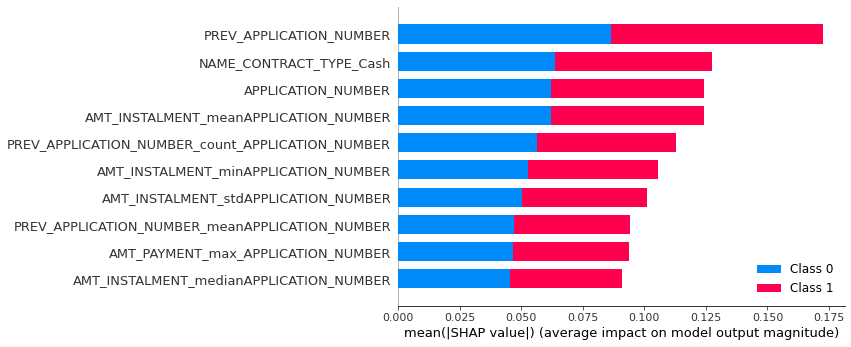

In [28]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

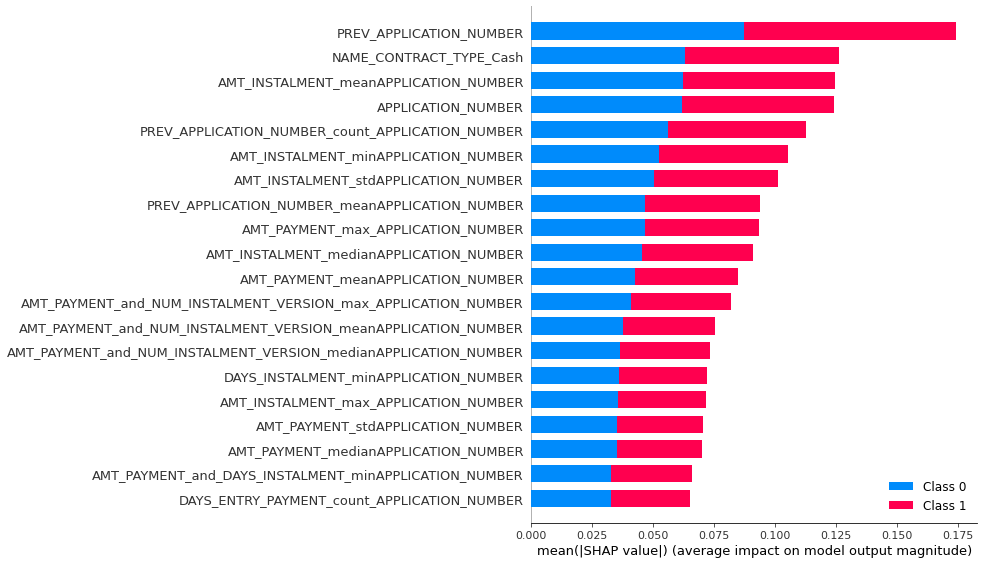

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [30]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']
feature_importance

,col_name,feature_importance_vals
1,PREV_APPLICATION_NUMBER,22558.636511
84,NAME_CONTRACT_TYPE_Cash,16348.879425
19,AMT_INSTALMENT_meanAPPLICATION_NUMBER,16155.522104
0,APPLICATION_NUMBER,16074.271247
57,PREV_APPLICATION_NUMBER_count_APPLICATION_NUMBER,14570.736571
...,...,...
15,AMT_PAYMENT_and_AMT_INSTALMENT_stdAPPLICATION_...,465.421831
74,NUM_INSTALMENT_VERSION_stdAPPLICATION_NUMBER,409.112456
77,NUM_INSTALMENT_VERSION_max_APPLICATION_NUMBER,377.572681
2,NUM_INSTALMENT_VERSION,363.239875


In [33]:
feature_importance['feature_importance_vals'].mean()

6272.102145135458

In [34]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 6272]

In [35]:
feature_importance = feature_importance['col_name'].tolist()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_featured[feature_importance], 
                                                    train_featured['TARGET'], random_state=0)

In [37]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.673438	valid_1's auc: 0.58665
[400]	training's auc: 0.723502	valid_1's auc: 0.604427
[600]	training's auc: 0.75901	valid_1's auc: 0.614381
[800]	training's auc: 0.784884	valid_1's auc: 0.624302
[1000]	training's auc: 0.804785	valid_1's auc: 0.631559
[1200]	training's auc: 0.821846	valid_1's auc: 0.636911
[1400]	training's auc: 0.836688	valid_1's auc: 0.639084
[1600]	training's auc: 0.849778	valid_1's auc: 0.645395
[1800]	training's auc: 0.860136	valid_1's auc: 0.649574
[2000]	training's auc: 0.869709	valid_1's auc: 0.651898
[2200]	training's auc: 0.878266	valid_1's auc: 0.655046
[2400]	training's auc: 0.886688	valid_1's auc: 0.656582
[2600]	trainin

LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [38]:
train = train_featured[feature_importance].groupby('APPLICATION_NUMBER').mean()
test = test[feature_importance].groupby('APPLICATION_NUMBER').mean()

In [40]:
train

,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_Cash,AMT_INSTALMENT_meanAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_count_APPLICATION_NUMBER,AMT_INSTALMENT_minAPPLICATION_NUMBER,AMT_INSTALMENT_stdAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_meanAPPLICATION_NUMBER,AMT_PAYMENT_max_APPLICATION_NUMBER,AMT_INSTALMENT_medianAPPLICATION_NUMBER,AMT_PAYMENT_meanAPPLICATION_NUMBER,...,DAYS_ENTRY_PAYMENT_medianAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_stdAPPLICATION_NUMBER,DAYS_INSTALMENT_meanAPPLICATION_NUMBER,DAYS_INSTALMENT_max_APPLICATION_NUMBER,AMT_PAYMENT_minAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_minAPPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_meanAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_max_APPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_meanAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_medianAPPLICATION_NUMBER
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423341,4.830703e+07,1,123552256.0,2.000000,1.234233e+08,153654.609375,123423341.0,123727808.0,123528944.0,123552256.0,...,123599456.0,101735.742188,123601680.0,1.237791e+08,123423344.0,123423344.0,123423344.0,123779136.0,123598768.0,123423341.0
123423345,4.951309e+07,1,123423344.0,1.000000,1.234233e+08,NaN,123423345.0,123572232.0,123423344.0,123497792.0,...,123610544.0,102046.398438,123600560.0,1.237787e+08,123423344.0,123423344.0,123423344.0,123779392.0,123604560.0,123423345.0
123423349,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423351,4.959046e+07,1,123499360.0,2.000000,1.234234e+08,43849.199219,123423351.0,123566240.0,123507984.0,123498488.0,...,123601528.0,101938.679688,123601520.0,1.237793e+08,123423352.0,123423352.0,123423352.0,123779480.0,123602680.0,123423351.0
123423352,4.911637e+07,1,123512448.0,6.692308,1.234234e+08,106824.164062,123423352.0,123727688.0,123494888.0,123534280.0,...,123597752.0,102624.546875,123601008.0,1.237784e+08,123423352.0,123423352.0,123452704.0,123778808.0,123597840.0,123423352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730828,4.868465e+07,1,123659312.0,5.800000,1.235382e+08,86527.679688,123730828.0,123750256.0,123671664.0,123653304.0,...,123600256.0,103192.867188,123602320.0,1.237787e+08,123536360.0,123424672.0,123698216.0,123778336.0,123601752.0,123730828.0
123730830,4.947019e+07,1,123705096.0,1.666667,1.236536e+08,66868.132812,123730830.0,123730832.0,123730832.0,123705096.0,...,123605424.0,104295.289062,123607104.0,1.237795e+08,123653616.0,123423552.0,123730832.0,123778440.0,123606928.0,123730830.0
123730833,4.927415e+07,1,123681184.0,2.600000,1.235710e+08,81831.468750,123730833.0,123742488.0,123729048.0,123681184.0,...,123594816.0,103636.500000,123597336.0,1.237780e+08,123571016.0,123424704.0,123730832.0,123778288.0,123598864.0,123730833.0


In [41]:
test

,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_Cash,AMT_INSTALMENT_meanAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_count_APPLICATION_NUMBER,AMT_INSTALMENT_minAPPLICATION_NUMBER,AMT_INSTALMENT_stdAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_meanAPPLICATION_NUMBER,AMT_PAYMENT_max_APPLICATION_NUMBER,AMT_INSTALMENT_medianAPPLICATION_NUMBER,AMT_PAYMENT_meanAPPLICATION_NUMBER,...,DAYS_ENTRY_PAYMENT_medianAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_stdAPPLICATION_NUMBER,DAYS_INSTALMENT_meanAPPLICATION_NUMBER,DAYS_INSTALMENT_max_APPLICATION_NUMBER,AMT_PAYMENT_minAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_minAPPLICATION_NUMBER,AMT_PAYMENT_and_DAYS_INSTALMENT_meanAPPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_max_APPLICATION_NUMBER,DAYS_ENTRY_PAYMENT_meanAPPLICATION_NUMBER,PREV_APPLICATION_NUMBER_medianAPPLICATION_NUMBER
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423342,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423343,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423344,4.976389e+07,1,123478384.0,1.000000,1.234233e+08,77835.484375,123423344.0,123533424.0,123478384.0,123478384.0,...,123593496.0,102124.562500,123609088.0,1.237794e+08,123423344.0,123423344.0,123423344.0,123778752.0,123598432.0,123423344.0
123423346,4.939154e+07,1,123565816.0,1.666667,1.234233e+08,110587.148438,123423346.0,123714824.0,123551728.0,123571272.0,...,123599584.0,101032.242188,123599784.0,1.237777e+08,123423344.0,123423344.0,123423344.0,123778672.0,123600184.0,123423346.0
123423347,4.968425e+07,1,123568304.0,1.000000,1.234233e+08,130994.742188,123423347.0,123716304.0,123579288.0,123569088.0,...,123603728.0,102972.718750,123601200.0,1.237788e+08,123423344.0,123423344.0,123423344.0,123778672.0,123601200.0,123423347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730847,4.851000e+07,1,123730848.0,3.000000,1.237308e+08,0.000000,123730847.0,123744440.0,123730848.0,123690536.0,...,123605336.0,101279.140625,123608880.0,1.237782e+08,123634232.0,123424872.0,123730848.0,123774640.0,123603648.0,123730847.0
123730848,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123730849,4.984746e+07,1,123579456.0,4.750000,1.234335e+08,110428.328125,123730849.0,123746024.0,123571192.0,123607632.0,...,123604640.0,102327.109375,123600912.0,1.237791e+08,123479368.0,123424944.0,123715600.0,123778640.0,123604128.0,123730849.0


In [39]:
train.to_csv('train_payments.csv')
test.to_csv('test_payments.csv')